In [1]:
import numpy as np

import matplotlib.pylab as pl
import matplotlib.pyplot as plt
import seaborn as sns

import functions.xor_rxor_with_otp_functions as fn
from proglearn.sims import generate_gaussian_parity
from math import log2, ceil
from proglearn.progressive_learner import ProgressiveLearner
from proglearn.deciders import SimpleArgmaxAverage
from proglearn.transformers import (
    TreeClassificationTransformer,
    NeuralClassificationTransformer,
)
from proglearn.voters import TreeClassificationVoter, KNNClassificationVoter
from proglearn.sims import generate_gaussian_parity

from matplotlib.colors import ListedColormap
cmap_light = ListedColormap(['#FFBBBB', '#BBFFBB', '#BBBBFF'])
cmap_bold = ListedColormap(['#CC0000', '#00AA00', '#0000CC'])

In [14]:
#Function to rotate distribution
def rotate(X, theta=0, dim=[0,1]):
    #dimensions to rotate
    Z = X[:, dim]
    
    #rotation
    c, s = np.cos(theta), np.sin(theta)
    R = np.array([[c, -s], [s, c]])
    Z = Z @ R
    
    #recombine
    X[:, dim] = Z
    
    return X

#Function to shear in the X direction
def shearX(X, s=0, dim=[0,1]):
    #dimensions to shear
    Z = X[:, dim]
    
    #shear
    R = np.array([[1, 0], [s, 1]])
    Z = Z @ R
    
    #recombine
    X[:, dim] = Z
    
    return X

#Function to shear in the Y direction
def shearY(X, s=0, dim=[0,1]):
    #dimensions to shear
    Z = X[:, dim]
    
    #shear
    R = np.array([[1, s], [0, 1]])
    Z = Z @ R
    
    #recombine
    X[:, dim] = Z
    
    return X

#Function to double shear in the X direction
def double_shearX(X, y, ss=(0,0) , dim=[0,1]):
    #dimensions to shear
    Z = X[:, dim]
    i,j = dim
    t,b = ss
    
    Z_top = Z[Z[:,j] >= 0]
    Z_bot = Z[Z[:,j] < 0]
    c_top = y[Z[:,j] >= 0]
    c_bot = y[Z[:,j] < 0]
    
    #shear
    R_top = np.array([[1, 0], [t, 1]])
    R_bot = np.array([[1, 0], [b, 1]])
    Z_top = Z_top @ R_top
    Z_bot = Z_bot @ R_bot
    
    #recombine
    Z = np.concatenate((Z_top, Z_bot))
    y = np.concatenate((c_top, c_bot))
    X[:, dim] = Z
    
    return X, y

def get_colors(colors, inds):
    c = [colors[i] for i in inds]
    return c

In [15]:
l = 3
h = 0.05 
xx, yy = np.meshgrid(np.arange(-l, l, h), np.arange(-l, l, h))
grid = np.c_[xx.ravel(), yy.ravel()]

#distribution generation
X = [];
y = [];

S = [0, 0.5, 1, 1.5, 2, 3, 4, 5, 10];

for i in S:
    D,c = generate_gaussian_parity(500);
    D = shearX(D, s=i);
    
    X.append(D);
    y.append(c);

#Original XOR
U,v = generate_gaussian_parity(500);

In [16]:
#Prarameters
n_trees=10
max_depth=None

c = [];
p = [];

for i in range(len(S)):
    #Model
    default_transformer_class = TreeClassificationTransformer
    default_transformer_kwargs = {"kwargs" : {"max_depth" : max_depth}}

    default_voter_class = TreeClassificationVoter
    default_voter_kwargs = {}

    default_decider_class = SimpleArgmaxAverage
    default_decider_kwargs = {"classes" : np.arange(2)}
    progressive_learner = ProgressiveLearner(
        default_transformer_class = default_transformer_class,
        default_transformer_kwargs = default_transformer_kwargs,
        default_voter_class = default_voter_class,
        default_voter_kwargs = default_voter_kwargs,
        default_decider_class = default_decider_class,
        default_decider_kwargs = default_decider_kwargs)

    #Training and Prediction
    progressive_learner.add_task(U, v, num_transformers=n_trees)
    progressive_learner.add_task(X[i], y[i], num_transformers=n_trees)
    
    z = progressive_learner.predict(grid, task_id=0)
    q = progressive_learner.task_id_to_decider[0].predict_proba(grid)[:,0]
    
    #Store values
    c.append(z)
    p.append(q)

In [17]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

<ipython-input-18-15c9af64200b>:25: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, zz, cmap=cmap_light);
<ipython-input-18-15c9af64200b>:31: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, pp);


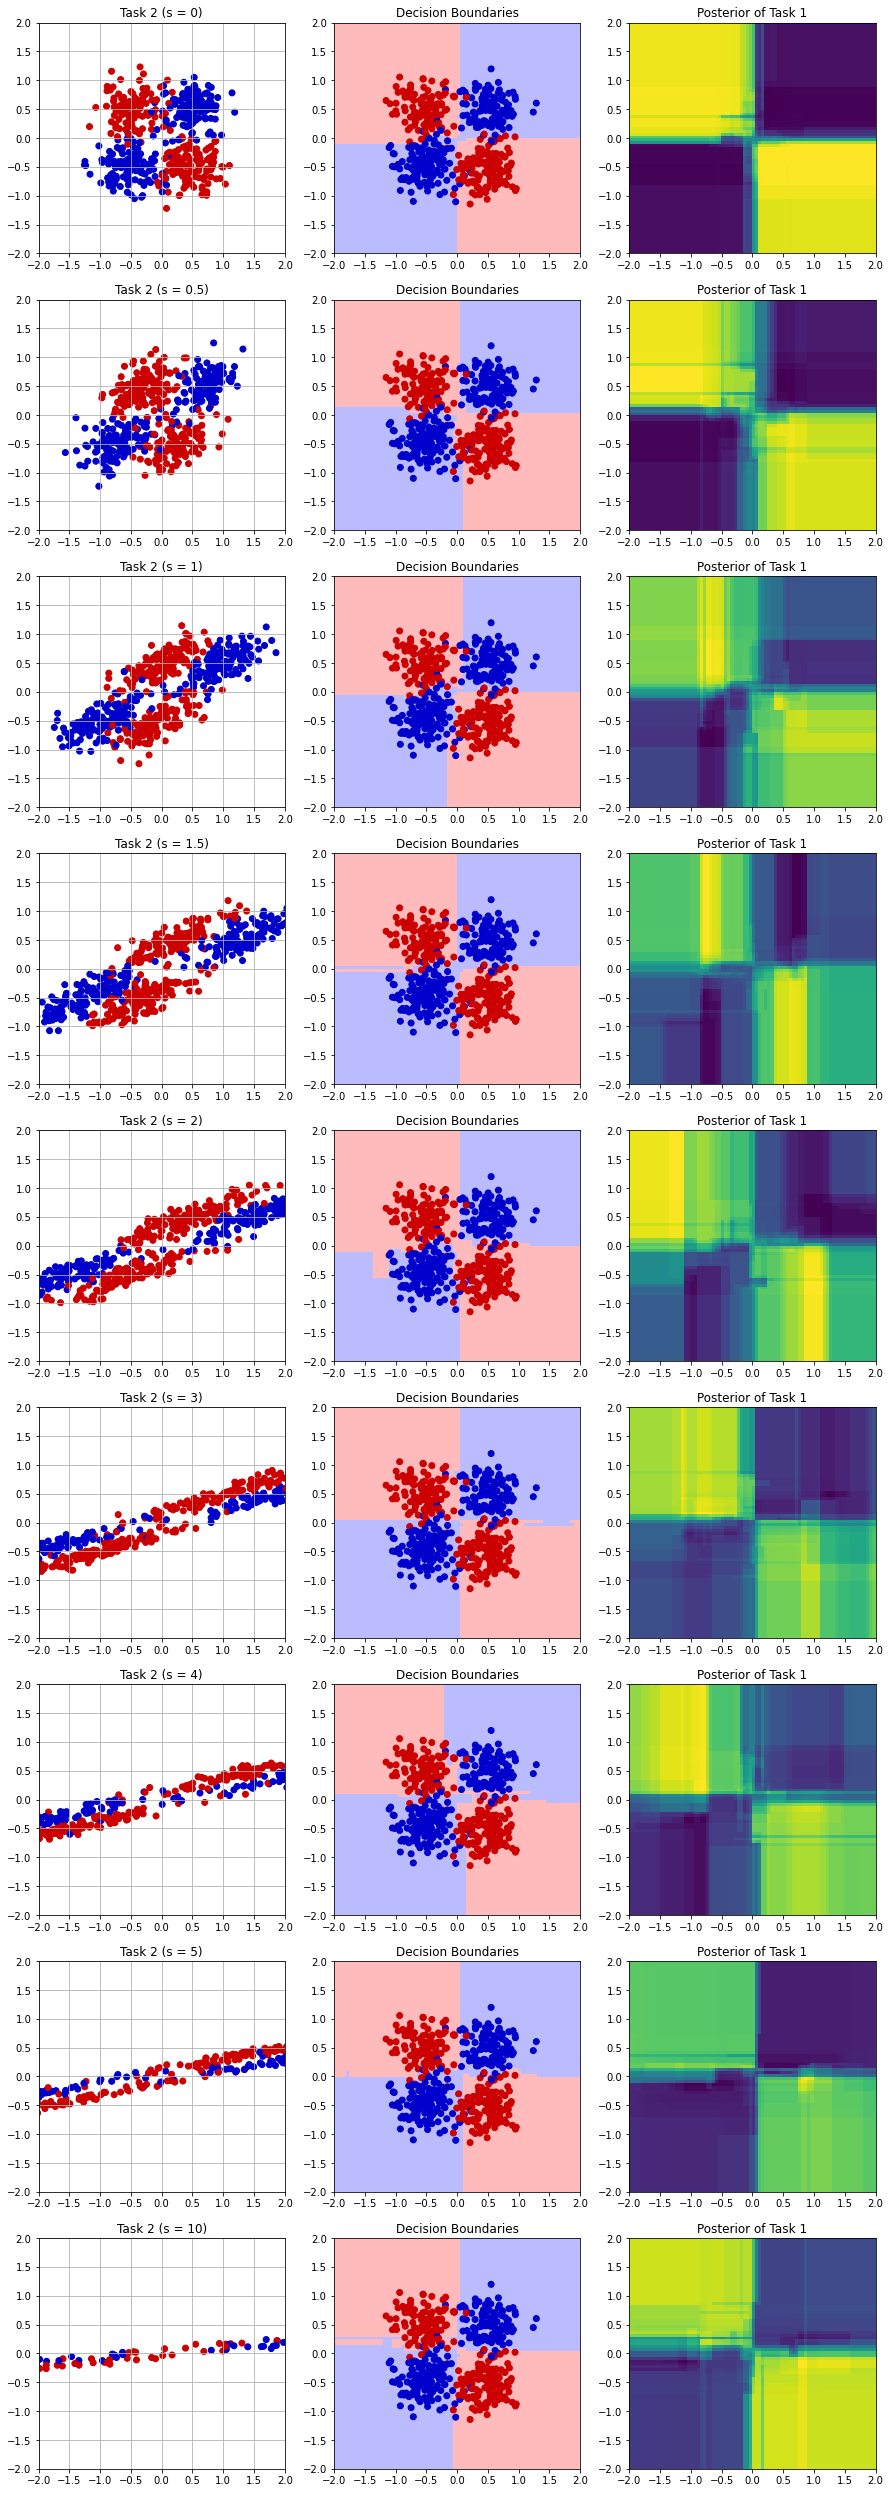

In [18]:
#Plot Decisions
l = 2;
w = 3;
n = len(S)
plt.figure(figsize=(w*5, n*5))

for i in range(n):
    #Decision Boundary
    zz = c[i];
    zz = zz.reshape(xx.shape);
    
    #Posteriors
    pp = p[i];
    pp = pp.reshape(xx.shape);
    
    #Task 2 Distribution
    x = X[i];
    
    plt.subplot(n,w, w*i+1);
    plt.scatter(x[:,0], x[:,1], c=y[i], cmap=cmap_bold);
    plt.xlim([-l,l]); plt.ylim([-l,l]);
    plt.grid(); plt.title('Task 2 (s = {})'.format(S[i]));
    
    plt.subplot(n,w, w*i+2);
    plt.pcolormesh(xx, yy, zz, cmap=cmap_light);
    plt.scatter(U[:,0], U[:,1], c=v, cmap=cmap_bold);
    plt.xlim([-l,l]); plt.ylim([-l,l]);
    plt.title('Decision Boundaries');
    
    plt.subplot(n,w, w*i+3);
    plt.pcolormesh(xx, yy, pp);
    plt.xlim([-l,l]); plt.ylim([-l,l]);
    plt.title('Posterior of Task 1');

In [19]:
h = 0.05 
xx1, yy1 = np.meshgrid(np.arange(-3, 3, h), np.arange(-3, 3, h))
grid1 = np.c_[xx1.ravel(), yy1.ravel()]

n_trees=10
max_depth=None

default_transformer_class = TreeClassificationTransformer
default_transformer_kwargs = {"kwargs": {"max_depth": max_depth}}

default_voter_class = TreeClassificationVoter
default_voter_kwargs = {}

default_decider_class = SimpleArgmaxAverage
default_decider_kwargs = {"classes": np.arange(2)}
progressive_learner = ProgressiveLearner(
    default_transformer_class=default_transformer_class,
    default_transformer_kwargs=default_transformer_kwargs,
    default_voter_class=default_voter_class,
    default_voter_kwargs=default_voter_kwargs,
    default_decider_class=default_decider_class,
    default_decider_kwargs=default_decider_kwargs,
)

#ot_sinkhorn = ot.da.SinkhornTransport(reg_e=1e-2)
#ot_sinkhorn.fit(Xs=X_task2.copy(), Xt=X_task1.copy(), ys=y_task2.copy(), yt=y_task1.copy())
#transp_Xs_sinkhorn = ot_sinkhorn.transform(Xs=X_task2.copy())
#X_task2 = transp_Xs_sinkhorn
        
#ot_lasso = ot.da.SinkhornL1l2Transport(reg_e=0.1, max_iter=30)
#ot_lasso.fit(Xs=X_task2.copy(), Xt=X_task1.copy(), ys=y_task2.copy(), yt=y_task1.copy())
#transp_Xs_lasso = ot_lasso.transform(Xs=X_task2.copy())
#X_task2 = transp_Xs_lasso

progressive_learner.add_task(X1, y1, num_transformers=n_trees)

progressive_learner.add_task(X4, y4, num_transformers=n_trees)

l2f_grid1 = progressive_learner.task_id_to_decider[0].predict_proba(grid1, transformer_ids=[0])[:,0]
l2f_grid1 = l2f_grid1.reshape(xx1.shape)

l2f_grid2 = progressive_learner.task_id_to_decider[1].predict_proba(grid1, transformer_ids=[1])[:,0]
l2f_grid2 = l2f_grid2.reshape(xx1.shape)

l2f_grid3 = progressive_learner.task_id_to_decider[0].predict_proba(grid1)[:,0]
l2f_grid3 = l2f_grid3.reshape(xx1.shape)

l2f_grid4 = progressive_learner.task_id_to_decider[1].predict_proba(grid1)[:,0]
l2f_grid4 = l2f_grid4.reshape(xx1.shape)

NameError: name 'X1' is not defined

In [16]:
vote_per_transformer_id = []
for transformer_id in progressive_learner.task_id_to_decider[0].transformer_id_to_voters.keys():
    vote_per_bag_id = []
    for bag_id in range(len(progressive_learner.task_id_to_decider[0].transformer_id_to_transformers[transformer_id])):
        transformer = progressive_learner.task_id_to_decider[0].transformer_id_to_transformers[transformer_id][bag_id]
        X_transformed = transformer.transform(grid1)
        voter = progressive_learner.task_id_to_decider[0].transformer_id_to_voters[transformer_id][bag_id]
        vote = voter.predict_proba(X_transformed)
        vote_per_bag_id.append(vote)
    vote_per_transformer_id.append(np.mean(vote_per_bag_id, axis=0))

In [17]:
first_votes = vote_per_transformer_id[0]
second_votes = vote_per_transformer_id[1]

<ipython-input-18-d806b674f204>:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx1, yy1, first_votes[:,0].reshape(xx1.shape));
<ipython-input-18-d806b674f204>:9: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx1, yy1, second_votes[:,0].reshape(xx1.shape));


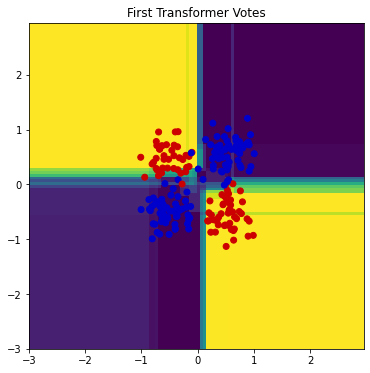

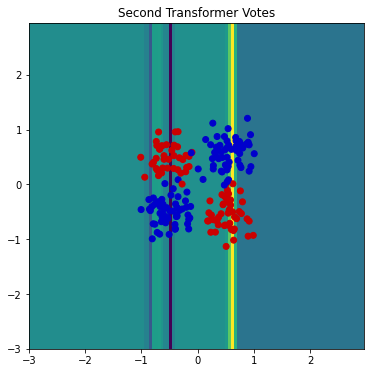

In [18]:
plt.figure(figsize=(6,6));
plt.pcolormesh(xx1, yy1, first_votes[:,0].reshape(xx1.shape));
plt.scatter(X1[:,0], X1[:,1], c=y1, cmap=cmap_bold);
plt.xlim(xx1.min(), xx1.max());
plt.ylim(yy1.min(), yy1.max());
plt.title('First Transformer Votes');

plt.figure(figsize=(6,6));
plt.pcolormesh(xx1, yy1, second_votes[:,0].reshape(xx1.shape));
plt.scatter(X1[:,0], X1[:,1], c=y1, cmap=cmap_bold);
plt.xlim(xx1.min(), xx1.max());
plt.ylim(yy1.min(), yy1.max());
plt.title('Second Transformer Votes');

<ipython-input-19-ffdec6d421d3>:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx1, yy1, l2f_grid1);
<ipython-input-19-ffdec6d421d3>:9: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx1, yy1, l2f_grid2);
<ipython-input-19-ffdec6d421d3>:16: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shadi

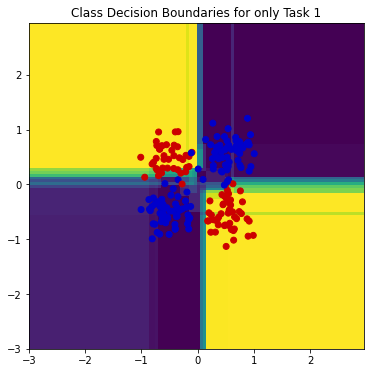

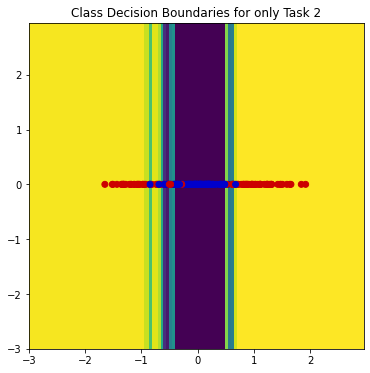

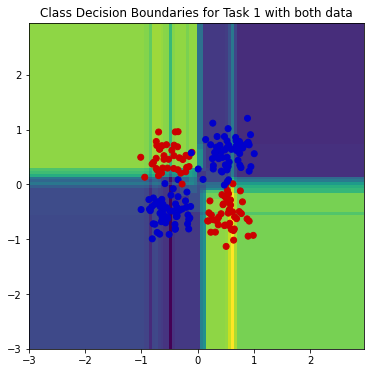

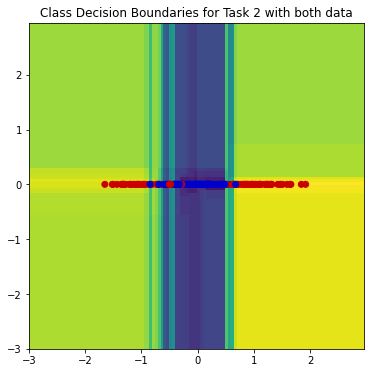

In [19]:
plt.figure(figsize=(6,6));
plt.pcolormesh(xx1, yy1, l2f_grid1);
plt.scatter(X1[:,0], X1[:,1], c=y1, cmap=cmap_bold);
plt.xlim(xx1.min(), xx1.max());
plt.ylim(yy1.min(), yy1.max());
plt.title('Class Decision Boundaries for only Task 1');

plt.figure(figsize=(6,6));
plt.pcolormesh(xx1, yy1, l2f_grid2);
plt.scatter(X4[:,0], X4[:,1], c=y1, cmap=cmap_bold);
plt.xlim(xx1.min(), xx1.max());
plt.ylim(yy1.min(), yy1.max());
plt.title('Class Decision Boundaries for only Task 2');

plt.figure(figsize=(6,6));
plt.pcolormesh(xx1, yy1, l2f_grid3);
plt.scatter(X1[:,0], X1[:,1], c=y1, cmap=cmap_bold);
plt.xlim(xx1.min(), xx1.max());
plt.ylim(yy1.min(), yy1.max());
plt.title('Class Decision Boundaries for Task 1 with both data');

plt.figure(figsize=(6,6));
plt.pcolormesh(xx1, yy1, l2f_grid4);
plt.scatter(X4[:,0], X4[:,1], c=y1, cmap=cmap_bold);
plt.xlim(xx1.min(), xx1.max());
plt.ylim(yy1.min(), yy1.max());
plt.title('Class Decision Boundaries for Task 2 with both data');

In [2]:
angle_sweep = np.arange(0,10,0.5)
task1_sample = 100
task2_sample = 100
mc_rep = 250

In [3]:
mean_te1 = fn.bte_v_angle(angle_sweep, task1_sample, task2_sample, mc_rep, register_cpd=False, register_otp=False)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   21.0s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:   25.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:   10.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:   11.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elap

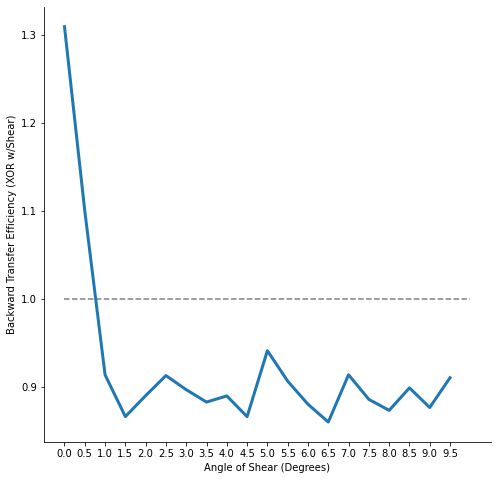

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.plot(angle_sweep, mean_te1, linewidth=3)
ax.set_xticks(np.arange(0, 10, 0.5))
ax.hlines(1, 0, 10, colors="gray", linestyles="dashed", linewidth=1.5)
ax.set_xlabel("Angle of Shear (Degrees)")
ax.set_ylabel("Backward Transfer Efficiency (XOR w/Shear)")

right_side = ax.spines["right"]
right_side.set_visible(False)
top_side = ax.spines["top"]
top_side.set_visible(False)

In [4]:
mean_te2 = fn.bte_v_angle(angle_sweep, task1_sample, task2_sample, mc_rep, register_cpd=True)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:   17.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   12.8s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:   17.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:   19.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elap

In [5]:
mean_te3 = fn.bte_v_angle(angle_sweep, task1_sample, task2_sample, mc_rep, register_otp=True)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   16.5s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:   21.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:   14.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:   17.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elap

In [6]:
mean_te4 = fn.bte_v_angle(angle_sweep, task1_sample, task2_sample, mc_rep, register_icp=True)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:   18.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:   17.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:   16.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elap

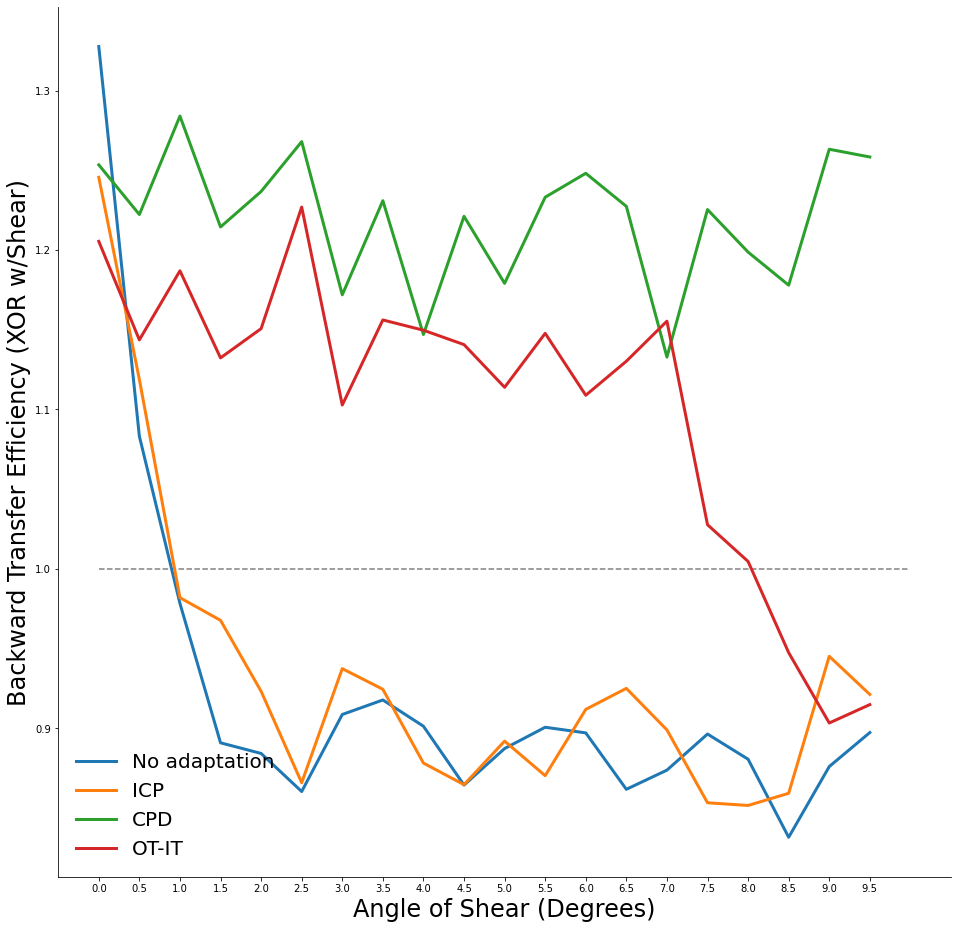

In [7]:
fontsize=24
fig, ax = plt.subplots(1, 1, figsize=(16, 16))
task = ["No adaptation", "ICP", "CPD", "OT-exact", "OT-IT"]
ax.plot(angle_sweep, mean_te1, linewidth=3, label=task[0])
ax.plot(angle_sweep, mean_te4, linewidth=3, label=task[1])
ax.plot(angle_sweep, mean_te2, linewidth=3, label=task[2])
ax.plot(angle_sweep, mean_te3, linewidth=3, label=task[4])
ax.set_xticks(np.arange(0, 10, 0.5))
ax.hlines(1, 0, 10, colors="gray", linestyles="dashed", linewidth=1.5)
ax.set_xlabel("Angle of Shear (Degrees)",fontsize=fontsize)
ax.set_ylabel("Backward Transfer Efficiency (XOR w/Shear)",fontsize=fontsize)
ax.legend(loc="lower left", fontsize=20, frameon=False)

right_side = ax.spines["right"]
right_side.set_visible(False)
top_side = ax.spines["top"]
top_side.set_visible(False)

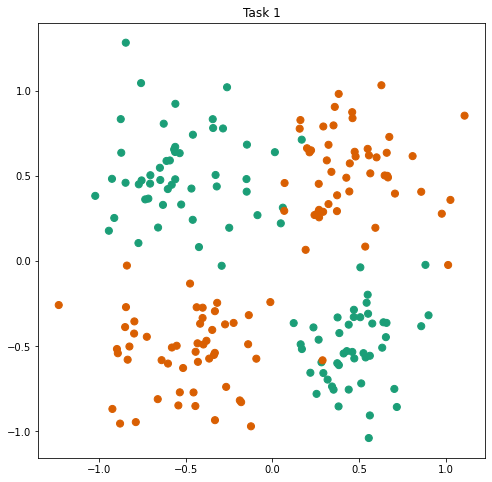

In [24]:
X1, y1 = generate_gaussian_parity(200)

def get_colors(colors, inds):
    c = [colors[i] for i in inds]
    return c

colors = sns.color_palette("Dark2", n_colors=2)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(X1[:,0], X1[:,1], c=get_colors(colors, y1), s=50)
#ax.axis("off")
plt.title('Task 1');
plt.show()

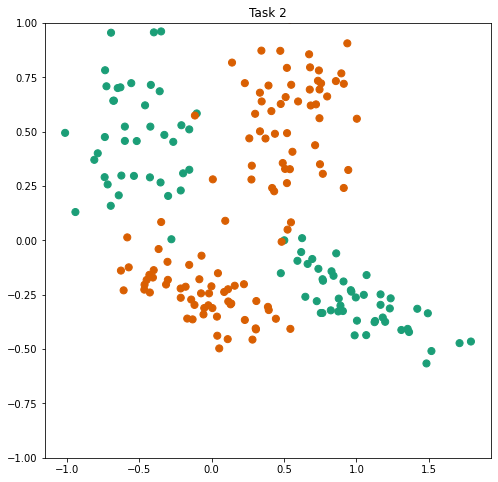

In [27]:
from skimage import transform

tform1 = transform.AffineTransform(shear=0*np.pi/180)
tform2 = transform.AffineTransform(shear=60*np.pi/180)

X1_top = X1[X1[:,1] >= 0]
X1_bottom = X1[X1[:,1] < 0]
y1_top = y1[X1[:,1] >= 0]
y1_bottom = y1[X1[:,1] < 0]

m = X1_top.shape[1]
src = np.ones((m + 1, X1_top.shape[0]))
src[:m, :] = np.copy(X1_top.T)

src = np.dot(tform1.params, src)
X4_top = src.T[:, 0:2]
y4_top = y1_top

m = X1_bottom.shape[1]
src = np.ones((m + 1, X1_bottom.shape[0]))
src[:m, :] = np.copy(X1_bottom.T)

src = np.dot(tform2.params, src)
X4_bottom = src.T[:, 0:2]
y4_bottom = y1_bottom

X4 = np.concatenate((X4_top, X4_bottom))
y4 = np.concatenate((y4_top, y4_bottom))

colors = sns.color_palette("Dark2", n_colors=2)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
#print(X4)
ax.scatter(X4[:,0], X4[:,1], c=get_colors(colors, y4), s=50)
plt.title('Task 2');
plt.ylim([-1, 1])
plt.show()

In [2]:
angle_sweep = range(0,91,10)
task1_sample = 100
task2_sample = 100
mc_rep = 500

In [3]:
mean_te1 = fn.bte_v_angle(angle_sweep, task1_sample, task2_sample, mc_rep)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   25.9s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   28.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   17.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   19.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   17.5s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   20.1s finished
[

In [4]:
mean_te2 = fn.bte_v_angle(angle_sweep, task1_sample, task2_sample, mc_rep, register_cpd=True)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   21.6s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   24.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   21.5s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   24.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   21.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   24.9s finished
[

In [5]:
mean_te3 = fn.bte_v_angle(angle_sweep, task1_sample, task2_sample, mc_rep, register_otp=True)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   24.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   27.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   25.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   28.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   28.0s finished
[

In [6]:
mean_te4 = fn.bte_v_angle(angle_sweep, task1_sample, task2_sample, mc_rep, register_icp=True)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   20.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   24.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   21.6s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   24.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   21.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   23.9s finished
[

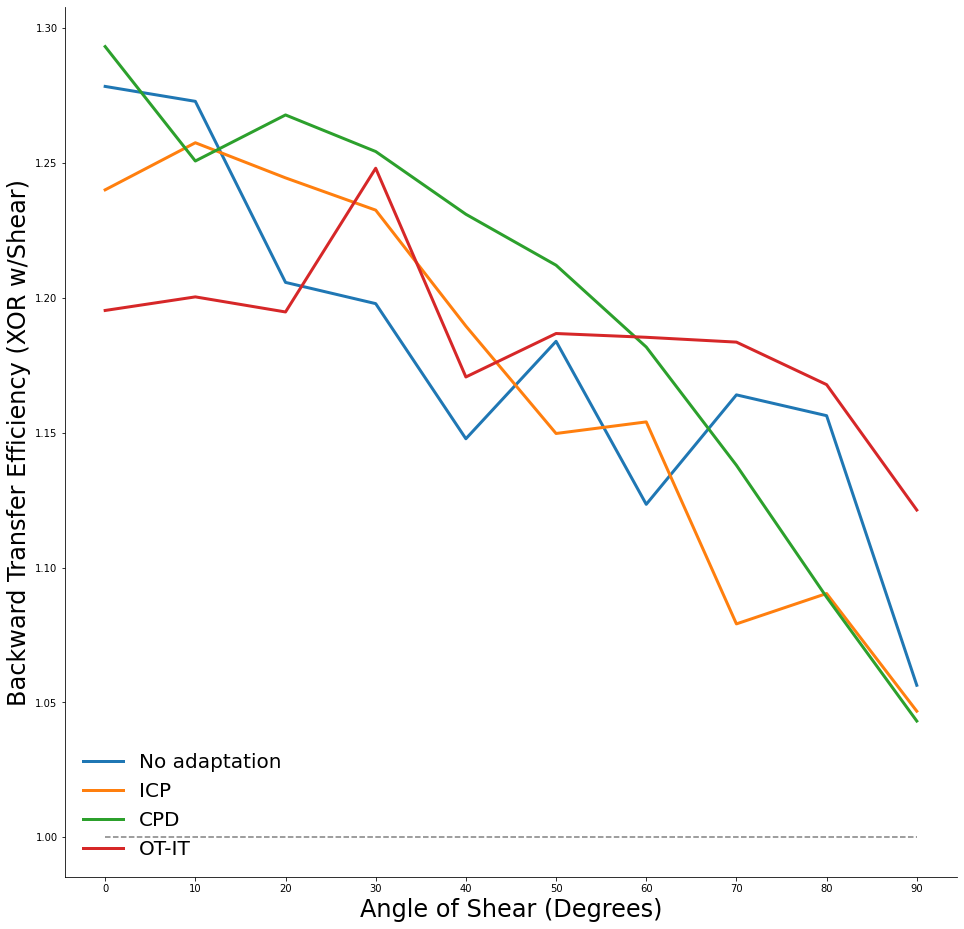

In [7]:
fontsize=24
fig, ax = plt.subplots(1, 1, figsize=(16, 16))
task = ["No adaptation", "ICP", "CPD", "OT-exact", "OT-IT"]
ax.plot(angle_sweep, mean_te1, linewidth=3, label=task[0])
ax.plot(angle_sweep, mean_te4, linewidth=3, label=task[1])
ax.plot(angle_sweep, mean_te2, linewidth=3, label=task[2])
ax.plot(angle_sweep, mean_te3, linewidth=3, label=task[4])
ax.set_xticks(range(0, 91, 10))
ax.hlines(1, 0, 90, colors="gray", linestyles="dashed", linewidth=1.5)
ax.set_xlabel("Angle of Shear (Degrees)",fontsize=fontsize)
ax.set_ylabel("Backward Transfer Efficiency (XOR w/Shear)",fontsize=fontsize)
ax.legend(loc="lower left", fontsize=20, frameon=False)

right_side = ax.spines["right"]
right_side.set_visible(False)
top_side = ax.spines["top"]
top_side.set_visible(False)

In [86]:
import keras

(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()
data_x = np.concatenate([X_train, X_test])
data_x = data_x.reshape((data_x.shape[0], data_x.shape[1] * data_x.shape[2]))
data_y = np.concatenate([y_train, y_test])

In [87]:
idx_1 = np.where(data_y == 0)[0]
idx_2 = np.where(data_y == 1)[0]

In [88]:
task1_x = np.concatenate((data_x[idx_1[0:500]], data_x[idx_2[0:500]]))
task2_x = np.concatenate((data_x[idx_1[500:1000]], data_x[idx_2[500:1000]]))

task1_y = np.concatenate((data_y[idx_1[0:500]], data_y[idx_2[0:500]]))
task2_y = np.concatenate((data_y[idx_2[500:1000]], data_y[idx_1[500:1000]]))

test_x = np.concatenate((data_x[idx_1[1000:1200]], data_x[idx_2[1000:1200]]))
test_y = np.concatenate((data_y[idx_1[1000:1200]], data_y[idx_2[1000:1200]]))

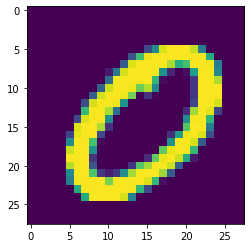

In [93]:
plt.imshow(task2_x[0].reshape(28, 28))

In [94]:
print(task2_y[0])

1


In [95]:
n_trees=10
max_depth=None

default_transformer_class = TreeClassificationTransformer
default_transformer_kwargs = {"kwargs": {"max_depth": max_depth}}

default_voter_class = TreeClassificationVoter
default_voter_kwargs = {}

default_decider_class = SimpleArgmaxAverage
default_decider_kwargs = {"classes": np.arange(2)}
progressive_learner = ProgressiveLearner(
    default_transformer_class=default_transformer_class,
    default_transformer_kwargs=default_transformer_kwargs,
    default_voter_class=default_voter_class,
    default_voter_kwargs=default_voter_kwargs,
    default_decider_class=default_decider_class,
    default_decider_kwargs=default_decider_kwargs,
)

#ot_sinkhorn = ot.da.SinkhornTransport(reg_e=1e-2)
#ot_sinkhorn.fit(Xs=X_task2.copy(), Xt=X_task1.copy(), ys=y_task2.copy(), yt=y_task1.copy())
#transp_Xs_sinkhorn = ot_sinkhorn.transform(Xs=X_task2.copy())
#X_task2 = transp_Xs_sinkhorn
        
#ot_lasso = ot.da.SinkhornL1l2Transport(reg_e=0.1, max_iter=30)
#ot_lasso.fit(Xs=X_task2.copy(), Xt=X_task1.copy(), ys=y_task2.copy(), yt=y_task1.copy())
#transp_Xs_lasso = ot_lasso.transform(Xs=X_task2.copy())
#X_task2 = transp_Xs_lasso

progressive_learner.add_task(task1_x, task1_y, num_transformers=n_trees)

progressive_learner.add_task(task2_x, task2_y, num_transformers=n_trees)

uf_task1 = progressive_learner.predict(test_x, transformer_ids=[0], task_id=0)
l2f_task1=progressive_learner.predict(test_x, task_id=0)

errors = np.zeros(6, dtype=float)
errors[0] = 1 - np.mean(uf_task1 == test_y)
errors[1] = 1 - np.mean(l2f_task1 == test_y)

print(errors)

[0.02   0.0125 0.     0.     0.     0.    ]


In [96]:
te = errors[0]/errors[1]
te

1.6000000000000072

In [4]:
mean_te2 = fn.bte_v_angle(angle_sweep, task1_sample, task2_sample, mc_rep, register=True)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    3.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    3.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    3.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    2.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Don

In [6]:
import functions.xor_rxor_with_icp_functions as fn1

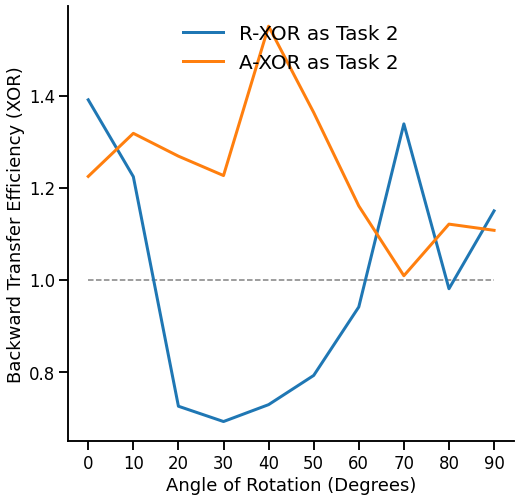

In [7]:
fn1.plot_bte_v_angle(angle_sweep, mean_te1, mean_te2)

In [7]:
mean_te_icp = fn1.bte_v_angle(angle_sweep, task1_sample, task2_sample, mc_rep, register=True)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done 1202 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done 1752 tasks      | elapsed:   21.7s
[Parallel(n_jobs=-1)]: Done 2402 tasks      | elapsed:   29.7s
[Parallel(n_jobs=-1)]: Done 3152 tasks      | elapsed:   38.9s
[Parallel(n_jobs=-1)]: Done 4002 tasks      | elapsed:   49.3s
[Parallel(n_jobs=-1)]: Done 4952 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed:  1.0min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: 

[Parallel(n_jobs=-1)]: Done 2402 tasks      | elapsed:   30.0s
[Parallel(n_jobs=-1)]: Done 3152 tasks      | elapsed:   39.4s
[Parallel(n_jobs=-1)]: Done 4002 tasks      | elapsed:   50.0s
[Parallel(n_jobs=-1)]: Done 4952 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed:  1.0min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 1202 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done 1752 tasks      | elapsed:   22.0s
[Parallel(n_jobs=-1)]: Done 2402 tasks      | elapsed:   30.1s
[Parallel(n_jobs=-1)]: Done 3152 tasks      | elapsed:   39.5s
[Parallel(n_jobs=-1)]: Done 4002 tasks      | elapsed:   50.0s
[Parallel(n_jobs=-1)]: Done 4952 ta

[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done 1202 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done 1752 tasks      | elapsed:   22.4s
[Parallel(n_jobs=-1)]: Done 2402 tasks      | elapsed:   30.6s
[Parallel(n_jobs=-1)]: Done 3152 tasks      | elapsed:   40.2s
[Parallel(n_jobs=-1)]: Done 4002 tasks      | elapsed:   51.0s
[Parallel(n_jobs=-1)]: Done 4952 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed:  1.1min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 1202 tasks

[Parallel(n_jobs=-1)]: Done 4002 tasks      | elapsed:   51.6s
[Parallel(n_jobs=-1)]: Done 4952 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed:  1.1min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 1202 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done 1752 tasks      | elapsed:   22.8s
[Parallel(n_jobs=-1)]: Done 2402 tasks      | elapsed:   31.1s
[Parallel(n_jobs=-1)]: Done 3152 tasks      | elapsed:   40.7s
[Parallel(n_jobs=-1)]: Done 4002 tasks      | elapsed:   51.7s
[Parallel(n_jobs=-1)]: Done 4952 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed:  1.1min finished
[Parallel(n_jobs=-1)]: Us

[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 1202 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 1752 tasks      | elapsed:   23.0s
[Parallel(n_jobs=-1)]: Done 2402 tasks      | elapsed:   31.4s
[Parallel(n_jobs=-1)]: Done 3152 tasks      | elapsed:   41.3s
[Parallel(n_jobs=-1)]: Done 4002 tasks      | elapsed:   52.3s
[Parallel(n_jobs=-1)]: Done 4952 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed:  1.1min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 1202 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 1752 tasks      | elapsed:   23.0s
[Parallel(n_jobs=-1)]: Done 2402 tas

[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed:  1.1min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 1202 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done 1752 tasks      | elapsed:   23.1s
[Parallel(n_jobs=-1)]: Done 2402 tasks      | elapsed:   31.6s
[Parallel(n_jobs=-1)]: Done 3152 tasks      | elapsed:   41.4s
[Parallel(n_jobs=-1)]: Done 4002 tasks      | elapsed:   52.5s
[Parallel(n_jobs=-1)]: Done 4952 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed:  1.1min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_

[Parallel(n_jobs=-1)]: Done 1752 tasks      | elapsed:   23.2s
[Parallel(n_jobs=-1)]: Done 2402 tasks      | elapsed:   31.8s
[Parallel(n_jobs=-1)]: Done 3152 tasks      | elapsed:   41.8s
[Parallel(n_jobs=-1)]: Done 4002 tasks      | elapsed:   52.9s
[Parallel(n_jobs=-1)]: Done 4952 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed:  1.1min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 1202 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done 1752 tasks      | elapsed:   23.2s
[Parallel(n_jobs=-1)]: Done 2402 tasks      | elapsed:   31.8s
[Parallel(n_jobs=-1)]: Done 3152 tasks      | elapsed:   41.6s
[Parallel(n_jobs=-1)]: Done 4002 ta

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 1202 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done 1752 tasks      | elapsed:   23.3s
[Parallel(n_jobs=-1)]: Done 2402 tasks      | elapsed:   31.9s
[Parallel(n_jobs=-1)]: Done 3152 tasks      | elapsed:   41.8s
[Parallel(n_jobs=-1)]: Done 4002 tasks      | elapsed:   53.1s
[Parallel(n_jobs=-1)]: Done 4952 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed:  1.1min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 752 tasks 

[Parallel(n_jobs=-1)]: Done 3152 tasks      | elapsed:   42.3s
[Parallel(n_jobs=-1)]: Done 4002 tasks      | elapsed:   53.8s
[Parallel(n_jobs=-1)]: Done 4952 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed:  1.1min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 1202 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done 1752 tasks      | elapsed:   23.8s
[Parallel(n_jobs=-1)]: Done 2402 tasks      | elapsed:   32.5s
[Parallel(n_jobs=-1)]: Done 3152 tasks      | elapsed:   42.6s
[Parallel(n_jobs=-1)]: Done 4002 tasks      | elapsed:   53.9s
[Parallel(n_jobs=-1)]: Done 4952 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 5000 ou

In [8]:
mean_te_cpd = fn2.bte_v_angle(angle_sweep, task1_sample, task2_sample, mc_rep, adaptation=True)